In [96]:
include("../Source/types.jl")
include("../Source/functions.jl")

testSystem (generic function with 2 methods)

# System constants

In [97]:

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 68     # System length
T = 1.0   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 1000    # Number of measurements
Δt = 400  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

Controls(1.0471975511965976, 0.4, 3.0)

In [98]:
f

-0.11764705882352941

In [99]:
(t₀, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂) = findEquilibrium(syst, sim);

Finding Equilibrium of
SystConstants(68, 1.0, 11.11111111111111, 0.3, -0.11764705882352941, 1.0)
Controls(1.0471975511965976, 0.4, 3.0)
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 4003!
Checking if average is close to 0..
Average was not close to 0. Increasing interval.
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 5064!
Checking if average is close to 0..
Equilibrium found at time 13835
over the interval [5064, 7595]
s.t. <ΔE> = 19.25 ± 2.5
std(ΔE) = 127.3


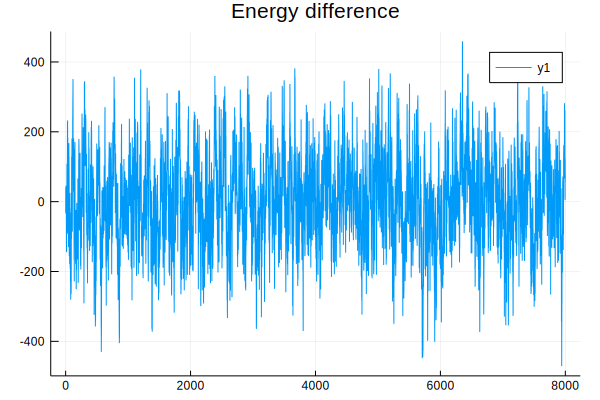

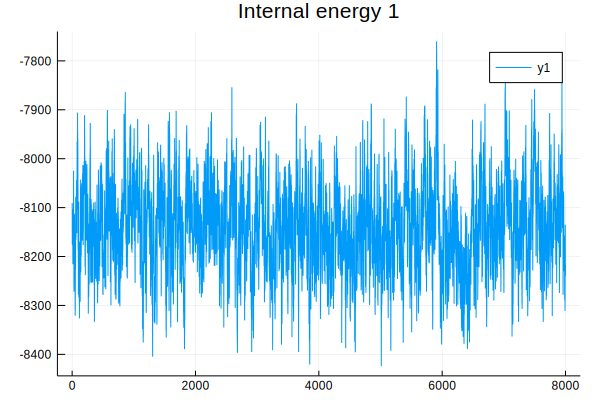

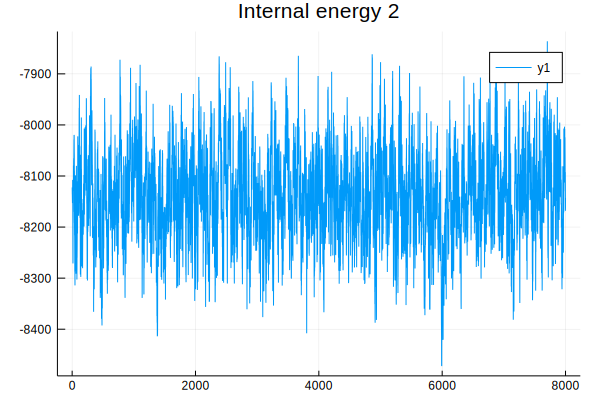

In [108]:
N = size(dE, 1)
int = 1:N
plt = plot(int, dE[int], title="Energy difference")
display(plt)
plt = plot(int, E₁[int], title="Internal energy 1")
display(plt)
plt = plot(int, E₂[int], title="Internal energy 2")
display(plt)

In [101]:
for i = 1:t₀
    mcSweep!(ψ₂)
    mcSweep!(ψ₁)
    print("$(round(i/t₀*100,2))%\r")
end

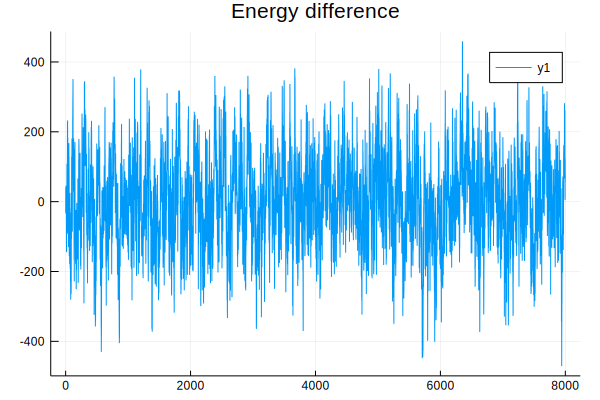

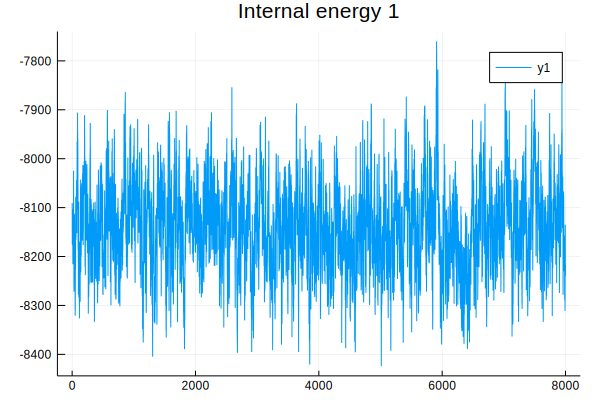

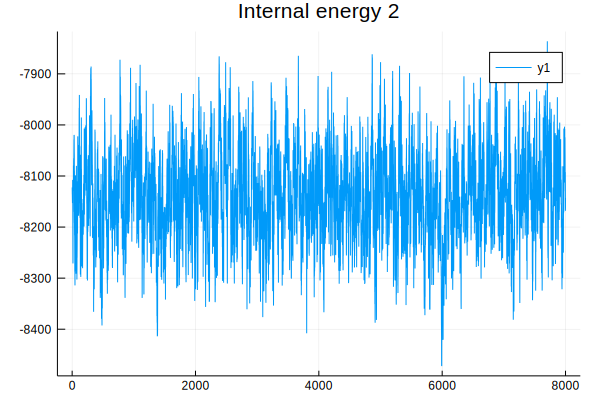

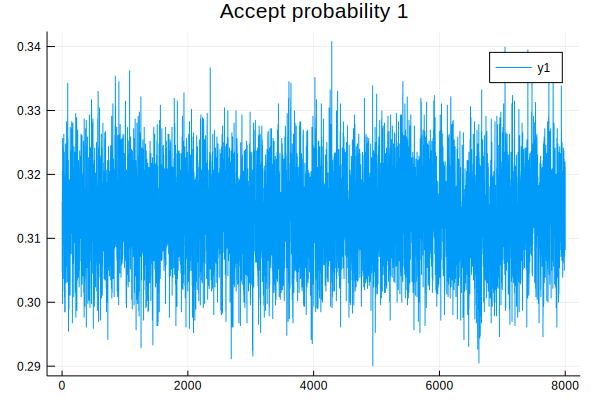

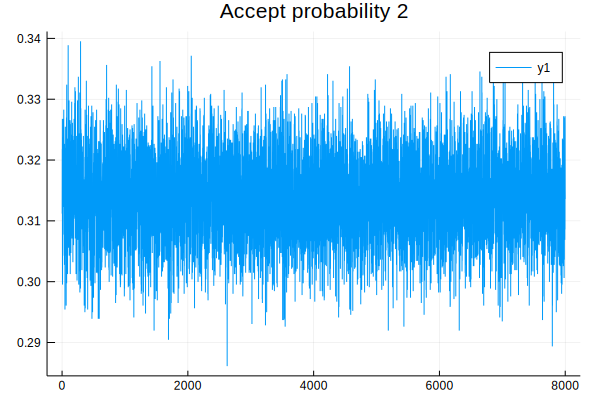

In [102]:
T = 4000
dE = zeros(2T)
E₁ = zeros(2T)
E₂ = zeros(2T)
p₁ = zeros(2T)
p₂ = zeros(2T)
for i = 1:T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end
adjustSimConstants!(sim₁, ψ₁)
adjustSimConstants!(sim₂, ψ₂)
for i = T+1:2T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end

# Plotting results
plt = plot(1:2T, dE, title="Energy difference")
display(plt)
plt = plot(1:2T, E₁, title="Internal energy 1")
display(plt)
plt = plot(1:2T, E₂, title="Internal energy 2")
display(plt)
plt = plot(1:2T, p₁, title="Accept probability 1")
display(plt)
plt = plot(1:2T, p₂, title="Accept probability 2")
display(plt)

# Plotting Vorticity

In [103]:
# Take in a matrix of k-values and calculate both the vorticity of θ⁺ and θ⁻.
# Same as previous structureFunction, but now assumes the state is at equilibrium
function structureFunctionAvg!{T<:Real}(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64)
    syst = ψ.consts
    Lky = size(ks, 1)
    Lkx = size(ks, 2)
    S⁺ = [zeros(M) for y=1:Lky, x=1:Lkx]    # Matrix containing the series of measurements for each k
    S⁻ = [zeros(M) for y=1:Lky, x=1:Lkx]
    Sm⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    Sm⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    s_norm_inv = 1/(syst.f*syst.L^2*two_pi)^2
    
    println("Making measurements over a $(Lkx)×$(Lky) matrix of ks.")
    # Loop over M measurements
    for m = 1:M
        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim)
        end
        
        # Make measurements 
        for y = 1:Lky, x = 1:Lkx
            (S⁺[y,x][m], S⁻[y,x][m]) = s_norm_inv.*structureFunction(ks[y,x], ψ)
            Sm⁺[y,x] += S⁺[y,x][m]^2
            Sm⁻[y,x] += S⁻[y,x][m]^2
        end
    end
    
    # Return average and error estimates
    avS⁺ = [mean(S⁺[y,x]) for y=1:Lky, x=1:Lkx]
    avS⁻ = [mean(S⁻[y,x]) for y=1:Lky, x=1:Lkx]
    τ⁺ = [autocorrTime(S⁺[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    τ⁻ = [autocorrTime(S⁻[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    errS⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    errS⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    
    for y=1:Lky, x=1:Lkx
        Sm⁺[y,x] /= M
        Sm⁻[y,x] /= M
        errS⁺[y,x] = (1+2*τ⁺[y,x])*(Sm⁺[y,x] - avS⁺[y,x]^2)/(M-1)
        errS⁻[y,x] = (1+2*τ⁻[y,x])*(Sm⁻[y,x] - avS⁻[y,x]^2)/(M-1)
    end
    
    return (avS⁺, errS⁺, avS⁻, errS⁻)
end

structureFunctionAvg! (generic function with 2 methods)

In [115]:
pos = [34,35]
@show errS⁺[pos...]
@show avS⁺[pos...]

errS⁺[pos...] = 3.3643121958338078e-18
avS⁺[pos...] = 0.9999999999999999


0.9999999999999999

In [104]:
M = 100
Δt = 100
ψ = copy(ψ₁)
sim = copy(sim₁)

Controls(1.0471975511965976, 0.4, 0.2633744855967078)

Making measurements over a 68×68 matrix of ks.


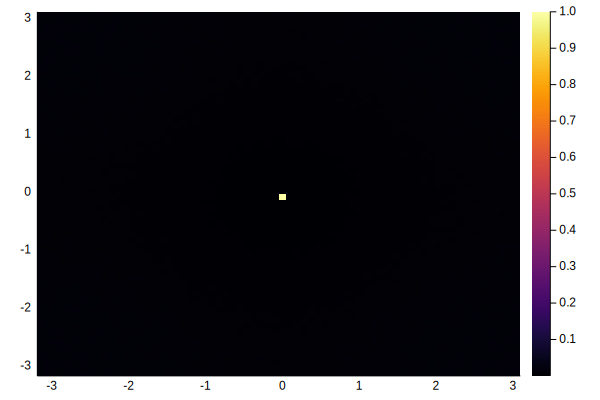

In [105]:
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]

# Calculate thermal average
(avS⁺, errS⁺, avS⁻, errS⁻) = structureFunctionAvg!(k_matrix, ψ, sim, M, Δt)

# Plot result for + component
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺)

S⁺(-π, π) = 0.00970882857066086 ± 2.7140476506557755e-6
S⁺(0, 0) = 0.008755171820179364 ± 1.947992905393668e-6


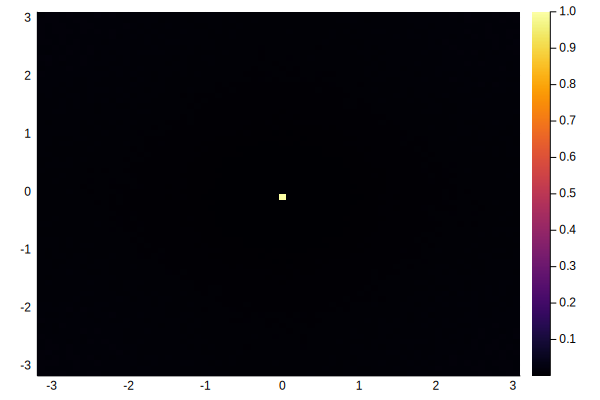

In [106]:
println("S⁺(-π, π) = $(avS⁺[1,1]) ± $(errS⁺[1,1])")
println("S⁺(0, 0) = $(avS⁺[9,10]) ± $(errS⁺[9,10])")
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁻)

In [121]:
avS⁺[Int(ceil(L/2)), Int(ceil(1+L/2))] = avS⁺[Int(ceil(1+L/2)), Int(ceil(L/2))]

3.5204868334350675e-5

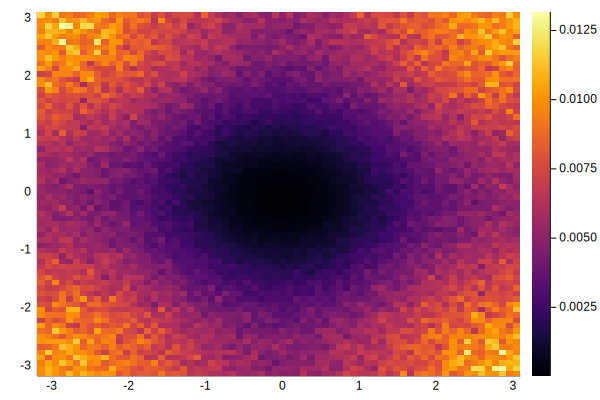

In [122]:
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺)

In [124]:
avS⁻[Int(ceil(L/2)), Int(ceil(1+L/2))] = avS⁻[Int(ceil(1+L/2)), Int(ceil(L/2))]

3.3362636883116486e-5

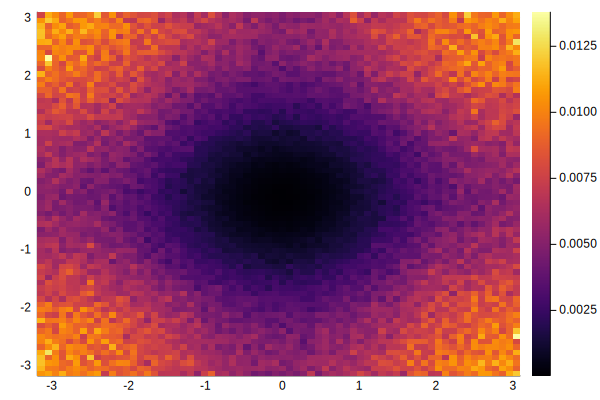

In [125]:
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁻)